# Main imports and code

In [ ]:
from IPython.display import clear_output

In [ ]:
# check which gpu we're using
!nvidia-smi

Fri Mar  4 17:25:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers
!pip install tensorboardx
!pip install simpletransformers

clear_output()

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval

In [ ]:
!pip install texthero
!pip install -U textblob
!python -m textblob.download_corpora
!pip install nlpaug

clear_output()

In [ ]:
import os
import re
import string

from tqdm.notebook import tqdm
tqdm.pandas()

import numpy as np
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style= "darkgrid" )

from textblob import TextBlob,Word

import nlpaug.augmenter.word as naw

import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('omw-1.4')
nltk.download("stopwords")
cached_stopwords = stopwords.words("english")

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


## Fetch Don't Patronize Me! data manager module

In [ ]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [ ]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [ ]:
!wget https://raw.githubusercontent.com/LordLean/SemEval-2022-Task-4/main/dontpatronizeme_v1.4/dontpatronizeme_pcl.tsv
# !wget https://raw.githubusercontent.com/LordLean/SemEval-2022-Task-4/main/dontpatronizeme_v1.4/dontpatronizeme_categories.tsv

!wget https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv
!wget https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv

# load test
!wget https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/TEST/task4_test.tsv

clear_output()

In [ ]:
from dont_patronize_me import DontPatronizeMe

dpm = DontPatronizeMe('.', '.')
dpm.load_task1()



## Rebuild datasets (Task 1)

In [ ]:
def load_training(csv):
  rows = [] # will contain par_id, label and text
  # encode categorical data
  keyword_code = {keyword : val for val, keyword in enumerate(dpm.train_task1_df.keyword.unique().tolist())}
  country_code = {country : val for val, country in enumerate(dpm.train_task1_df.country.unique().tolist())}
  for idx in range(len(csv)):  
    parid = csv.par_id[idx]
    #print(parid)
    # select row from original dataset to retrieve `text` and binary label
    text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
    label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
    keyword = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].keyword.values[0]
    country = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].country.values[0]
    orig_label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].orig_label.values[0]
    rows.append({
        'par_id':parid,
        "keyword":keyword,
        "keyword_code":keyword_code[keyword],
        "country":country,
        "country_code":country_code[country],
        'text':text,
        'label':label,
        "orig_label":orig_label
    })
  return pd.DataFrame(rows)



def load_test():
  """
  Return test dataframe in correct format.
  """
  rows=[]
  with open(os.path.join('.', 'task4_test.tsv')) as f:
    for line in f.readlines():
      par_id=line.strip().split('\t')[0]
      art_id = line.strip().split('\t')[1]
      keyword=line.strip().split('\t')[2]
      country=line.strip().split('\t')[3]
      t=line.strip().split('\t')[4]#.lower()
      l=line.strip().split('\t')[-1]
      if l=='0' or l=='1':
        lbin=0
      else:
        lbin=1
      rows.append(
        {'par_id':par_id,
        'art_id':art_id,
        'keyword':keyword,
        'country':country,
        'text':t, 
        'label':lbin, 
        'orig_label':l
        }
        )
  df=pd.DataFrame(rows, columns=['par_id', 'art_id', 'keyword', 'country', 'text', 'label', 'orig_label']) 
  return df

# Load data

In [ ]:
# load paragraph ids
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

In [ ]:
trdf1 = load_training(trids)
tedf1 = load_training(teids)
test_df = load_test()

In [ ]:
trdf1

,par_id,keyword,keyword_code,country,country_code,text,label,orig_label
0,4341,poor-families,9,gb,7,"The scheme saw an estimated 150,000 children f...",1,4
1,4136,homeless,6,za,6,Durban 's homeless communities reconciliation ...,1,2
2,10352,poor-families,9,lk,17,The next immediate problem that cropped up was...,1,4
3,8279,vulnerable,7,nz,3,Far more important than the implications for t...,1,2
4,1164,poor-families,9,gh,1,To strengthen child-sensitive social protectio...,1,4
...,...,...,...,...,...,...,...,...
8370,8380,refugee,4,gb,7,Rescue teams search for survivors on the rubbl...,0,0
8371,8381,hopeless,0,ke,18,The launch of ' Happy Birthday ' took place la...,0,0
8372,8382,homeless,6,pk,8,"The unrest has left at least 20,000 people dea...",0,0
8373,8383,hopeless,0,pk,8,You have to see it from my perspective . I may...,0,0


# Data Analysis of the Training Data

In [ ]:
trdf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8375 entries, 0 to 8374
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   par_id        8375 non-null   object
 1   keyword       8375 non-null   object
 2   keyword_code  8375 non-null   int64 
 3   country       8375 non-null   object
 4   country_code  8375 non-null   int64 
 5   text          8375 non-null   object
 6   label         8375 non-null   int64 
 7   orig_label    8375 non-null   object
dtypes: int64(3), object(5)
memory usage: 523.6+ KB


In [ ]:
trdf1.head()

,par_id,keyword,keyword_code,country,country_code,text,label,orig_label
0,4341,poor-families,9,gb,7,"The scheme saw an estimated 150,000 children f...",1,4
1,4136,homeless,6,za,6,Durban 's homeless communities reconciliation ...,1,2
2,10352,poor-families,9,lk,17,The next immediate problem that cropped up was...,1,4
3,8279,vulnerable,7,nz,3,Far more important than the implications for t...,1,2
4,1164,poor-families,9,gh,1,To strengthen child-sensitive social protectio...,1,4


In [ ]:
trdf1.label.value_counts()

0    7581
1     794
Name: label, dtype: int64

In [ ]:
neg, pos = trdf1.label.value_counts()
print("Class 0: {} samples\nClass 0: {}%\n\nClass 1: {} samples\nClass 1: {}%".format(neg, round(neg/len(trdf1)*100,2), pos, round(pos/len(trdf1)*100,2)))

Class 0: 7581 samples
Class 0: 90.52%

Class 1: 794 samples
Class 1: 9.48%


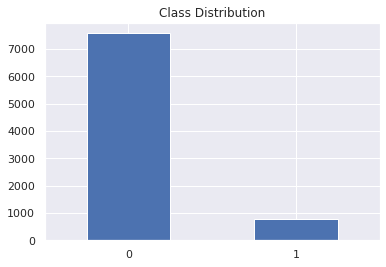

In [ ]:
trdf1.label.value_counts().plot.bar(rot=0, title="Class Distribution")

In [ ]:
def not_stopwords(token_list):

  total_len = len(token_list)
  clean_len = len([word for word in token_list if word not in cached_stopwords])

  return float(clean_len/total_len)

In [ ]:
def df_analysis(df):

  df["tokens"] = df["text"].apply(lambda x: [token.lower() for token in word_tokenize(x)])
  # length of each sentence in characters.
  df["num_char"] = df["text"].apply(lambda x: len(x))
  # length of each sentence in tokens.
  df["num_token"] = df["tokens"].apply(lambda x: len(x))
  # percent of text not included in stopword list.
  df["semantic"] = df["text"].apply(lambda x: not_stopwords(x))
  # sentiment - polarity
  df["sentiment_polarity"] = df["text"].apply(lambda x : TextBlob(x).sentiment.polarity)
  # sentiment - subjectivity
  df["sentiment_subjectivity"] = df["text"].apply(lambda x : TextBlob(x).sentiment.subjectivity)

  return df

In [ ]:
trdf1 = df_analysis(trdf1)

In [ ]:
trdf1.head(3)

,par_id,keyword,keyword_code,country,country_code,text,label,orig_label,tokens,num_char,num_token,semantic,sentiment_polarity,sentiment_subjectivity
0,4341,poor-families,9,gb,7,"The scheme saw an estimated 150,000 children f...",1,4,"[the, scheme, saw, an, estimated, 150,000, chi...",203,36,0.645320,0.025,0.337500
1,4136,homeless,6,za,6,Durban 's homeless communities reconciliation ...,1,2,"[durban, 's, homeless, communities, reconcilia...",51,6,0.607843,0.000,0.000000
2,10352,poor-families,9,lk,17,The next immediate problem that cropped up was...,1,4,"[the, next, immediate, problem, that, cropped,...",398,72,0.610553,-0.300,0.533333


In [ ]:
trdf1.describe()

,keyword_code,country_code,label,num_char,num_token,semantic,sentiment_polarity,sentiment_subjectivity
count,9047.000000,9047.000000,9047.000000,9047.000000,9047.000000,9047.000000,9047.000000,9047.000000
mean,4.496629,9.348513,0.162043,266.375705,49.575218,0.641840,0.023420,0.390699
std,2.815846,5.789247,0.368510,159.695147,29.515370,0.034720,0.201667,0.213047
min,0.000000,0.000000,0.000000,8.000000,1.000000,0.481928,-1.000000,0.000000
25%,2.000000,4.000000,0.000000,169.000000,31.000000,0.620030,-0.075000,0.266667
50%,5.000000,9.000000,0.000000,234.000000,43.000000,0.641104,0.000000,0.400000
75%,7.000000,14.000000,0.000000,329.000000,61.500000,0.662698,0.132111,0.513333
max,9.000000,19.000000,1.000000,5501.000000,918.000000,0.888889,1.000000,1.000000


In [ ]:
corr = trdf1.corr(method="pearson")
corr.style.background_gradient(cmap="coolwarm")

,keyword_code,country_code,label,num_char,num_token,semantic,sentiment_polarity,sentiment_subjectivity
keyword_code,1.000000,0.012586,0.053864,-0.029332,-0.033653,0.071871,-0.054117,0.086011
country_code,0.012586,1.000000,-0.028517,0.036244,0.026549,-0.029149,-0.025074,-0.028399
label,0.053864,-0.028517,1.000000,0.037579,0.055120,0.029431,0.027852,0.046048
num_char,-0.029332,0.036244,0.037579,1.000000,0.983236,-0.031774,0.093692,0.134636
num_token,-0.033653,0.026549,0.055120,0.983236,1.000000,0.025782,0.104692,0.149597
semantic,0.071871,-0.029149,0.029431,-0.031774,0.025782,1.000000,0.014499,-0.007997
sentiment_polarity,-0.054117,-0.025074,0.027852,0.093692,0.104692,0.014499,1.000000,0.105199
sentiment_subjectivity,0.086011,-0.028399,0.046048,0.134636,0.149597,-0.007997,0.105199,1.000000


# Modelling

## Data Augmentation

In [ ]:
# Create back translator obj.
aug = naw.BackTranslationAug()
# Create synonym augmentor obj.
aug_syn = naw.SynonymAug(aug_src='wordnet', aug_max=None)

clear_output()

In [ ]:
# Maximum token length.
MAX_LEN = 80

# Create sub dataframe of only positive samples with number of tokens less than MAX_LEN.
min_class_df = trdf1[(trdf1.label == 1) & (trdf1.num_token<=MAX_LEN)]

# Sample smaller amount due to time complexity of back translation.
min_class_df = min_class_df.sample(frac=1)

In [ ]:
# Apply back translation data augmentation.
aug_trans_df = min_class_df.copy()
aug_trans_df.text = min_class_df.text.progress_apply(lambda x : aug.augment(x))

  0%|          | 0/672 [00:00<?, ?it/s]

In [ ]:
# Apply synonym data augmentation.
aug_final_df = aug_trans_df.copy()
aug_final_df.text = aug_trans_df.text.progress_apply(lambda x : aug_syn.augment(x))

  0%|          | 0/672 [00:00<?, ?it/s]

In [ ]:
# N.B. this cell can be used to download generated augmentations from a saved file.

# # Get augmented samples.
# !wget https://raw.githubusercontent.com/LordLean/SemEval-2022-Task-4/main/dontpatronizeme_v1.4/augmented.csv
# aug_final_df = pd.read_csv("augmented.csv")

--2022-03-04 17:28:28--  https://raw.githubusercontent.com/LordLean/SemEval-2022-Task-4/main/dontpatronizeme_v1.4/augmented.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 470940 (460K) [text/plain]
Saving to: ‘augmented.csv’

augmented.csv       100%[===================>] 459.90K  --.-KB/s    in 0.03s   

2022-03-04 17:28:28 (12.9 MB/s) - ‘augmented.csv’ saved [470940/470940]



In [ ]:
# Concatenate original dataframe with augmented dataframe.
trdf1 = pd.concat([trdf1, aug_final_df])

Class 0: 7581 samples
Class 0: 83.8%

Class 1: 1466 samples
Class 1: 16.2%



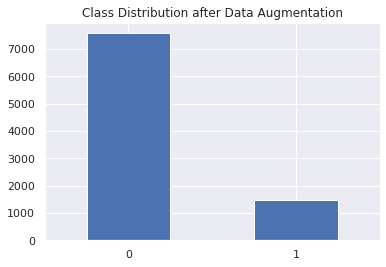

In [ ]:
neg, pos = trdf1.label.value_counts()
print("Class 0: {} samples\nClass 0: {}%\n\nClass 1: {} samples\nClass 1: {}%\n".format(neg, round(neg/len(trdf1)*100,2), pos, round(pos/len(trdf1)*100,2)))
trdf1.label.value_counts().plot.bar(rot=0, title="Class Distribution after Data Augmentation")

## Preprocessing

In [ ]:
def lemmatize_text(text):
 
  lemmatized = []
  for token in text:
    word1 = Word(token).lemmatize("n")
    word2 = Word(word1).lemmatize("v")
    word3 = Word(word2).lemmatize("a")
    lemmatized.append(Word(word3).lemmatize())

  return lemmatized

In [ ]:
def preprocess(df_, config={}):

  df = df_.copy()

  df["clean"] = df["text"]
  # remove digits
  df["clean"] = df["clean"].apply(lambda x : re.sub('\w*\d\w*','', x)) if config.get("digits", True) == True else df["clean"]
  # remove uppercase
  df["clean"] = df["clean"].apply(lambda x : x.lower()) if config.get("case", True) == True else df["clean"]
  # remove punc
  df["clean"] = df["clean"].apply(lambda x : re.sub('[%s]' % re.escape(string.punctuation), '', x)) if config.get("punc", True) == True else df["clean"]
  # remove excess whitespace
  df['clean'] = df['clean'].apply(lambda x : re.sub(' +',' ',x)) if config.get("whitespace", True) == True else df["clean"]
  # tokenize
  df["clean"] = df["clean"].apply(lambda x : word_tokenize(x))
  # stopword removal
  df["clean"] = df["clean"].apply(lambda x : [word for word in x if word not in cached_stopwords]) if config.get("stopword_removal", False) == True else df["clean"]
  # lemmatize
  df["clean"] = df["clean"].apply(lambda x : lemmatize_text(x)) if config.get("lemmatize", True) == True else df["clean"]
  # stem
  ...
  # join text
  df["clean"] = df["clean"].apply(lambda x : " ".join(x))

  return df

In [ ]:
config = {
    "digits" : True,
    "case" : True,
    "punc" : True,
    "whitespace" : True,
    "stopword_removal" : False,
    "lemmatize" : True,
}

trdf1 = preprocess(trdf1, config)

## Create training and evaluation sets

In [ ]:
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

# training set
text_column = "clean" # text or clean
training_set = pd.concat([pcldf,trdf1[trdf1.label==0].sample(frac=1)[:int(npos*2)]])
training_set = training_set[[text_column, "label"]].sample(frac=1)

# evaluation set
eval_set = tedf1[["text", "label"]].sample(frac=1)

Class 0: 2932 samples
Class 0: 66.67%

Class 1: 1466 samples
Class 1: 33.33%


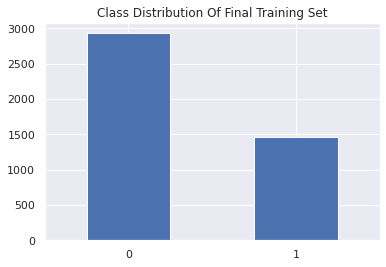

In [ ]:
neg, pos = training_set.label.value_counts()
print("Class 0: {} samples\nClass 0: {}%\n\nClass 1: {} samples\nClass 1: {}%".format(neg, round(neg/len(training_set)*100,2), pos, round(pos/len(training_set)*100,2)))
training_set.label.value_counts().plot.bar(rot=0, title="Class Distribution Of Final Training Set")

## RoBERTa Baseline for Task 1

In [ ]:
MAX_LEN = 80

model_args = ClassificationArgs()
model_args.num_train_epochs = 10
model_args.learning_rate = 1e-5
model_args.train_batch_size = 32
model_args.weight_decay = 1e-8
model_args.max_seq_length = MAX_LEN

model_args.eval_batch_size = 32
model_args.evaluate_during_training = True
model_args.evaluate_each_epoch = True,
model_args.evaluate_during_training_silent = False

model_args.use_early_stopping = True
model_args.early_stopping_consider_epochs = True
model_args.early_stopping_metric = "eval_loss"
model_args.early_stopping_metric_minimize = True
model_args.early_stopping_patience = 3

model_args.no_cache = True
model_args.no_save = True
model_args.overwrite_output_dir = True
model_args.reprocess_input_data = True

model_args.labels_list = [0, 1]

In [ ]:
model = ClassificationModel(
    "roberta", 
    'roberta-large', 
    args = model_args, 
    num_labels=2,
    weight = [0.5, 1],
    use_cuda=cuda_available
)

# train model
train_outputs = model.train_model(training_set, eval_df=eval_set)

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/4398 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/138 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 3


Running Epoch 1 of 10:   0%|          | 0/138 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/138 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 1
INFO:simpletransformers.classification.classification_model: Early stopping patience: 3


Running Epoch 3 of 10:   0%|          | 0/138 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 2
INFO:simpletransformers.classification.classification_model: Early stopping patience: 3


Running Epoch 4 of 10:   0%|          | 0/138 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: No improvement in eval_loss
INFO:simpletransformers.classification.classification_model: Current step: 3
INFO:simpletransformers.classification.classification_model: Early stopping patience: 3


Running Epoch 5 of 10:   0%|          | 0/138 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/66 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Patience of 3 steps reached
INFO:simpletransformers.classification.classification_model: Training terminated.
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.


## Evaluation

### Dev set predictions

In [ ]:
# run predictions on dev set
preds, _ = model.predict(eval_set.text.tolist())

y_true = eval_set.label.to_list()

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1895
           1       0.58      0.56      0.57       199

    accuracy                           0.92      2094
   macro avg       0.77      0.76      0.76      2094
weighted avg       0.92      0.92      0.92      2094



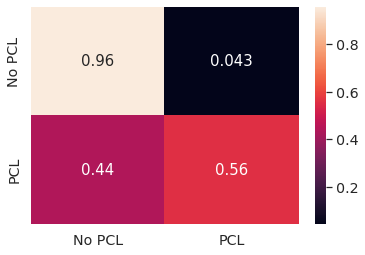

In [ ]:
# no preprocessing:
print(classification_report(y_true, preds))
conf_mat = confusion_matrix(y_true, preds, normalize="true")
conf_mat = pd.DataFrame(conf_mat, index=["No PCL", "PCL"], columns=["No PCL", "PCL"])
plt.figure(figsize = (6,4))
sns.set(font_scale=1.3)
sns.heatmap(conf_mat, annot=True, annot_kws={"size":15})

In [ ]:
print(np.unique(y_true, return_counts=1))
print(np.unique(preds, return_counts=1))

(array([0, 1]), array([1895,  199]))
(array([0, 1]), array([1902,  192]))


### Predict on Test Dataset

In [ ]:
import os

def load_test_df():
		"""
		Return test dataframe in correct format.
		"""
		rows=[]
		with open(os.path.join('.', 'task4_test.tsv')) as f:
			for line in f.readlines():
				par_id=line.strip().split('\t')[0]
				art_id = line.strip().split('\t')[1]
				keyword=line.strip().split('\t')[2]
				country=line.strip().split('\t')[3]
				t=line.strip().split('\t')[4]#.lower()
				l=line.strip().split('\t')[-1]
				if l=='0' or l=='1':
					lbin=0
				else:
					lbin=1
				rows.append(
					{'par_id':par_id,
					'art_id':art_id,
					'keyword':keyword,
					'country':country,
					'text':t, 
					'label':lbin, 
					'orig_label':l
					}
					)
		df=pd.DataFrame(rows, columns=['par_id', 'art_id', 'keyword', 'country', 'text', 'label', 'orig_label']) 
		return df

In [ ]:
test_df = load_test_df()

In [ ]:
test_preds, _ = model.predict(test_df.text.tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/3832 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
with open("task1.txt", "w") as outfile:
  for pi in test_preds:
    str_pi = str(pi)
    outfile.write("{}\n".format(str_pi + " "))

In [ ]:
!zip -r "task1.zip" "task1.txt"

  adding: task1.txt (deflated 96%)


In [ ]:
from google.colab import files

files.download("task1.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>